In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, Dropout, BatchNormalization, Add, GlobalAveragePooling2D, concatenate
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

2024-07-06 07:44:57.832540: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-06 07:44:57.864121: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-06 07:44:58.538724: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

# Function to load images from a folder
def load_images_from_folder(folder, augmentation=False):
    images = []
    datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                                 shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest') if augmentation else None

    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = preprocess_image(img_path)
        if img is not None:
            if augmentation:
                img = np.expand_dims(img, axis=0)
                for batch in datagen.flow(img, batch_size=1):
                    images.append(batch[0])
                    break
            else:
                images.append(img)

    return np.array(images)


In [3]:

def preprocess_image(image_path):
    # Load the image in grayscale
    img = load_img(image_path, color_mode='grayscale', target_size=(128, 128))
    img = img_to_array(img).astype('uint8')
    
    # Apply GaussianBlur to reduce noise and improve edge detection
    img = cv2.GaussianBlur(img, (13, 13), 0)
    
    # Apply adaptive thresholding to handle varying lighting conditions
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 3)
    
    # Apply edge detection
    edges = cv2.Canny(img, threshold1=75, threshold2=200)
    
    # Dilate the edges to broaden the lines
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    
    # Invert the edges: detected edges should be black, and the rest should be white
    edges = cv2.bitwise_not(edges)
    
    # Normalize the image
    edges = edges / 255.0
    edges = np.expand_dims(edges, axis=-1)
    
    return edges


In [4]:

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path is not None:
            processed_img = preprocess_image(img_path)
            images.append(processed_img)
    return images


In [5]:

def create_dataset(base_path):
    X = []
    y = []
    for person_id in range(1, 65):  # Assuming you have 64 persons
        if person_id in [5,7,8,10,11]:
            continue
        person_id = str(person_id).zfill(3)
        real_folder = os.path.join(base_path, person_id)
        forge_folder = os.path.join(base_path, f"{person_id}_forg")

        real_images = load_images_from_folder(real_folder)
        forge_images = load_images_from_folder(forge_folder)

        for img in real_images:
            X.append(img)
            y.append(0)  # Label for genuine signatures

        for img in forge_images:
            X.append(img)
            y.append(1)  # Label for forged signatures

    X = np.array(X)
    y = np.array(y)
    X = X / 255.0  # Normalize the images
    X = X.reshape(-1, 128, 128, 1)  # Reshape for the CNN
    return X, y

base_path = 'sign_data/train'
X, y = create_dataset(base_path)

In [6]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

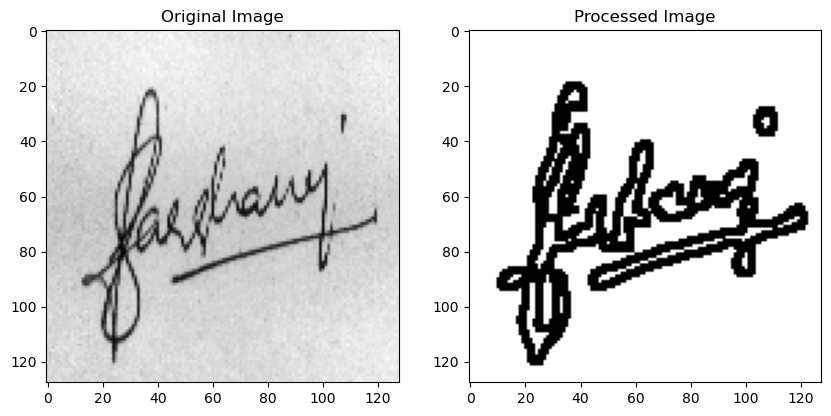

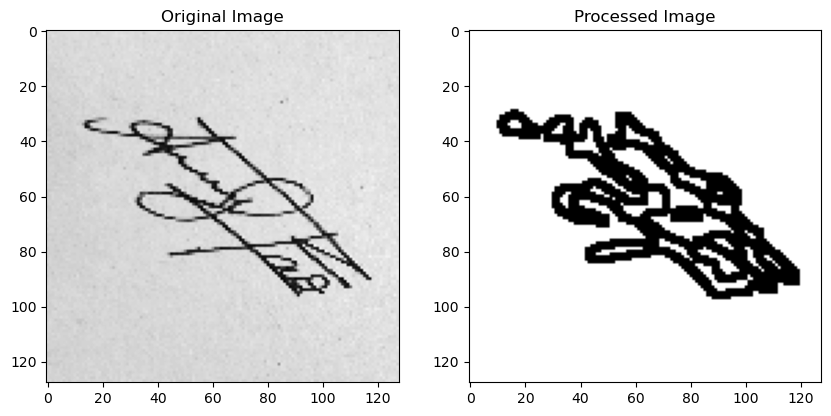

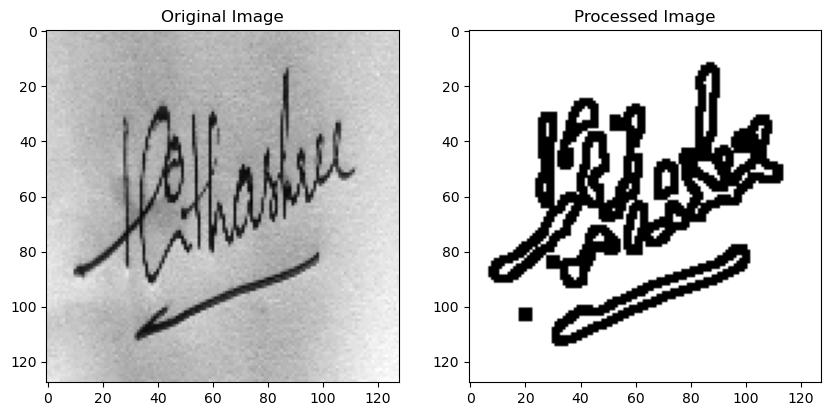

In [7]:

# Display a single image before and after preprocessing
def display_image_before_after(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (128, 128))
    processed_img = preprocess_image(file_path)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img_resized, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('Processed Image')
    plt.imshow(processed_img, cmap='gray')
    plt.show()

# Example image display
example_image_path = 'img4.jpeg'  # Provide a valid image path here
display_image_before_after(example_image_path)
# Example image display
example_image_path = 'img1.jpeg'  # Provide a valid image path here
display_image_before_after(example_image_path)
# Example image display
example_image_path = 'real.jpeg'  # Provide a valid image path here
display_image_before_after(example_image_path)

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import DepthwiseConv2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Add, Input, Activation, concatenate, Reshape, multiply, Attention
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler

def squeeze_excite_block(input, ratio=16):
    init = input
    channel_axis = -1
    filters = init.shape[channel_axis]

    se_shape = (1, 1, filters)
    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = multiply([init, se])
    return x

def residual_block(x, filters, kernel_size=(3, 3), stride=1):
    res = Conv2D(filters, (1, 1), strides=stride, padding='same')(x)
    
    x = DepthwiseConv2D(kernel_size, padding='same', strides=stride, activation='relu')(x)
    x = Conv2D(filters, (1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Add()([x, res])
    x = Activation('relu')(x)
    x = squeeze_excite_block(x)
    return x

def build_enhanced_model(input_shape=(128, 128, 1)):
    inputs = Input(shape=input_shape)
    
    # Initial convolutional block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Residual blocks
    x = residual_block(x, 128)
    x = MaxPooling2D((2, 2))(x)
    
    x = residual_block(x, 256)
    x = MaxPooling2D((2, 2))(x)
    
    x = residual_block(x, 512)
    x = MaxPooling2D((2, 2))(x)
    
    x = residual_block(x, 1024)
    x = MaxPooling2D((2, 2))(x)

    x = residual_block(x, 2048)
    x = MaxPooling2D((2, 2))(x)

    # Global Average Pooling and final dense layers
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    optimizer = AdamW(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

model = build_enhanced_model()

# Callbacks
callbacks = [
    LearningRateScheduler(lr_schedule),
]

2024-07-06 06:42:32.521788: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-06 06:42:32.544492: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 64, 64,    │        640 │ max_pooling2d[0]… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      8,320 │ depthwise_conv2d… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ add[0][0]         │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ activation[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 128) │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 8)   │      1,024 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 128) │      1,024 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64, 64,    │          0 │ activation[0][0], │
│                     │ 128)              │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ multiply[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 32, 32,    │      1,280 │ max_pooling2d_1[… │
│ (DepthwiseConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     33,024 │ depthwise_conv2d

 Total params: 6,331,905 (24.15 MB)

 Trainable params: 6,323,841 (24.12 MB)

 Non-trainable params: 8,064 (31.50 KB)

In [10]:
# Train the model
history = model.fit(X_train, y_train, batch_size=18, epochs=50, validation_data=(X_test, y_test), callbacks=callbacks)
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 33s 354ms/step - accuracy: 0.5251 - loss: 0.6922 - val_accuracy: 0.4935 - val_loss: 0.6942 - learning_rate: 1.0000e-04
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 364ms/step - accuracy: 0.5496 - loss: 0.6864 - val_accuracy: 0.4935 - val_loss: 0.6936 - learning_rate: 1.0000e-04
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 27s 351ms/step - accuracy: 0.5752 - loss: 0.6776 - val_accuracy: 0.5065 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 26s 342ms/step - accuracy: 0.5934 - loss: 0.6677 - val_accuracy: 0.5065 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 26s 340ms/step - accuracy: 0.6256 - loss: 0.6365 - val_accuracy: 0.4935 - val_loss: 0.6977 - learning_rate: 1.0000e-04
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 26s 338ms/step - accuracy: 0.6823 - loss: 0.5973 - val_accuracy: 0.4935 - val_loss: 0.7368 - learning_rate: 1.0000e-04
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 26s 339ms/step - acc

In [10]:
# Save the model
model.save('enhanced_signature_verification_model3.keras')

NameError: name 'model' is not defined

In [11]:
from tensorflow.keras.models import Model, load_model
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
models=[]
models.append(load_model("enhanced_signature_verification_model2.keras"))
models.append(load_model("enhanced_signature_verification_model3.keras"))

2024-07-06 07:45:45.284197: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-06 07:45:45.311682: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:

def preprocess_image(image_path):
    # Load the image in grayscale
    img = load_img(image_path, color_mode='grayscale', target_size=(128, 128))
    img = img_to_array(img).astype('uint8')
    
    # Apply edge detection
    edges = cv2.Canny(img, threshold1=30, threshold2=100)
    
    # Dilate the edges to broaden the lines
    kernel = np.ones((3,3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    
    # Invert the edges: detected edges should be black, and the rest should be white
    edges = cv2.bitwise_not(edges)
    
    # Normalize the image
    edges = edges / 255.0
    edges = np.expand_dims(edges, axis=-1)
    
    return edges


In [13]:
def preprocess_image1(image_path):
    processed_img = preprocess_image(image_path)
    processed_img = processed_img / 255.0
    processed_img = processed_img.reshape(1, 128, 128, 1)
    return processed_img

def predict_signature(model, real_signature_path, test_signature_path):
    real_img = preprocess_image1(real_signature_path)
    test_img = preprocess_image1(test_signature_path)
    
    real_pred = model.predict(real_img)
    test_pred = model.predict(test_img)
    
    difference = np.abs(real_pred - test_pred)
    return difference*100

In [37]:
# Example usage
real_signature_path = 'img1.jpeg'  # Provide a valid image path
test_signature_path = 'img2.jpeg'  # Provide a valid image path

In [38]:
for i,model in enumerate(models):
    difference = predict_signature(model, real_signature_path, test_signature_path)
    print(f"Difference: {difference} by model{i+1}\n\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Difference: [[1.9712374]] by model1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Difference: [[2.252318]] by model2




In [67]:
# Example usage
real_signature_path = 'img1.jpeg'  # Provide a valid image path
test_signature_path = 'img3.jpeg'  # Provide a valid image path

In [68]:
for i,model in enumerate(models):
    difference = predict_signature(model, real_signature_path, test_signature_path)
    print(f"Difference: {difference} by model{i+1}\n\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Difference: [[0.19784908]] by model1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Difference: [[0.6848175]] by model2




In [95]:
# Example usage
real_signature_path = 'img1.jpeg'   # Provide a valid image path
test_signature_path = 'img4.jpeg'  # Provide a valid image path

In [96]:
for i,model in enumerate(models):
    difference = predict_signature(model, real_signature_path, test_signature_path)
    print(f"Difference: {difference} by model{i+1}\n\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Difference: [[0.24207023]] by model1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Difference: [[98.91622]] by model2




In [15]:
# Example usage
real_signature_path = 'real.jpeg'   # Provide a valid image path
test_signature_path = 'real.jpeg'  # Provide a valid image path

In [16]:
for i,model in enumerate(models):
    difference = predict_signature(model, real_signature_path, test_signature_path)
    print(f"Difference: {difference} by model{i+1}\n\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Difference: [[0.]] by model1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Difference: [[0.]] by model2


